In [7]:
import sys

from matplotlib.axes import Axes
from matplotlib.figure import Figure

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib


from src.loader import is_game_already_saved
from src.gamedb import avg_last_5_or_less_offline
from src.utils import *
from src.gamedb import offline_games_df as offline_df

heatmap_score_min = 33.0
heatmap_score_max = 45.0
cmap = matplotlib.colormaps['RdYlGn']
gradient = np.linspace(heatmap_score_min, heatmap_score_max, 100)

def create_graph_for_game_id_and_team(game_id, highlighted_team_name, num_teams=0):
    if not is_game_already_saved(game_id):
        print(f"Game {game_id} was not found in the database, run loader first")
        exit(1)

    data = offline_df.loc[(game_id,), :]
    if num_teams == 0: num_teams = data.shape[0]
    q_set = data['question_set'].unique()[0]
    current_q_set_avg_by_round = offline_df.loc[offline_df.groupby('question_set').groups[q_set]].loc[:,'round_1':'round_7'].mean()
    last_50_offline_games_avg_by_round = offline_df.loc[list(offline_df.groupby('game_id').groups.keys())[-50:]].loc[:,'round_1':'round_7'].mean()
    all_scores = data.loc[:, 'round_1':'round_7']

    fig: Figure
    axs: list[Axes]
    # fig, axs = plt.subplots(9, 1, figsize=(10, 35), dpi=150, height_ratios=[0.1,1,1,1,1,1,1,1,1])
    fig, axs = plt.subplots(5, 2, figsize=(10, 35), dpi=150)

    heatmap:Axes = axs.flat[0]
    heatmap.tick_params(axis='y', which='both', left=False, labelleft=False)
    # heatmap.set_xticks(np.arange(heatmap_score_min, heatmap_score_max))
    # heatmap.colorbar(cmap. ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    for x in gradient:
        heatmap.bar(x, 0.1, color=cmap_color(x))
    heatmap.set_xticks(np.arange(heatmap_score_min, heatmap_score_max + 1, step=1))
    heatmap.margins(x=0, y=0)
    heatmap.set_title("Тепловая карта среднего (за все раунды) счёта команд за последние 5 игр")

    heatmap.legend(loc=(1.04, 0))


    total_score:Axes = axs.flat[1]
    for place, row in data.loc[:num_teams].iterrows():
        avg, color = color_by_rarity(avg_last_5_or_less_offline, row['team_name'])
        hatch = '//' if row['team_name'] == highlighted_team_name else None
        team_score = row.loc['final_score']
        # heatmap.axvline(team_score)
        bar = total_score.bar(place, team_score, hatch=hatch, width=1.0, edgecolor='w', linewidth=1, color=cmap_color(avg))
        total_score.margins(x=0, y=0.1)
        total_score.bar_label(bar)

    total_score.set_title("Общий счёт")

    ax: Axes
    for i, ax in enumerate(axs.flat[2:9]):
        round_number = i + 1
        round_name = f"round_{round_number}"

        ax.set_title(f"Раунд {round_number}")

        for place, row in data.loc[:num_teams].iterrows():
            avg, color = color_by_rarity(avg_last_5_or_less_offline, row['team_name'])
            team_name = f"{place}. {row['team_name']} ({'x̄₅ = ' + str(avg) if avg is not None else '-'})"
            hatch = '//' if row['team_name'] == highlighted_team_name else None
            team_score = row.loc[round_name]
            # plt.bar(place * bar_width, score, width=bar_width, color=color, hatch=hatch, alpha=0.7, label=team_name, edgecolor='black', linewidth=1)

            bar = ax.barh(place, team_score, label=team_name, hatch=hatch, height=1.0, edgecolor='w', linewidth=1, color=cmap_color(avg))

        # ax.axhline(all_scores.loc[:][round_name].mean(), color='black', linestyle='dotted', label=f'Среднее в этой игре (id={game_id})', alpha=0.6)
        # ax.axhline(last_50_offline_games_avg_by_round.loc[round_name], color='black', linestyle='solid',  label='Среднее за последние 50 игр', alpha=0.6)
        # ax.axhline(current_q_set_avg_by_round.loc[round_name], color='black', linestyle=(5, (10, 3)), label=f'Среднее по сету вопросов {q_set}', alpha=0.6)
        # ax.margins(x=0)
        ax.set_ylabel('Место')
        ax.set_xlabel('Количество очков')
        ax.invert_yaxis()

        ax.set_yticks(np.concatenate([np.arange(1, 10, step=1), np.arange(10, num_teams, step=5)]), np.concatenate([np.arange(1, 10, step=1), np.arange(10, num_teams, step=5)]))


    # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    # Set a common x and y label for all subplots
    # fig.text(0.5, 0.1, 'Team Name', ha='center', va='center')
    # fig.text(0.06, 0.5, 'Score', ha='center', va='center', rotation='vertical')

    # Set a common title for the figure
    fig.suptitle(f"Анализ игры #{game_id}",y=0.9, fontsize=16)

    # Adjust the layout
    # plt.tight_layout(h_pad=1,  rect=[0.05, 0.1, 0.95, 0.95])
    plt.subplots_adjust(
        hspace=0.4
    )

    # plt.subplot_tool()
    plt.show()


def legend_entry(color_hex):
    # move to notebook utils
    return Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor=color_hex[0], markeredgecolor='black', markersize=10)


def cmap_color(score):
    y = (score - heatmap_score_min) / (heatmap_score_max - heatmap_score_min)
    return cmap(y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


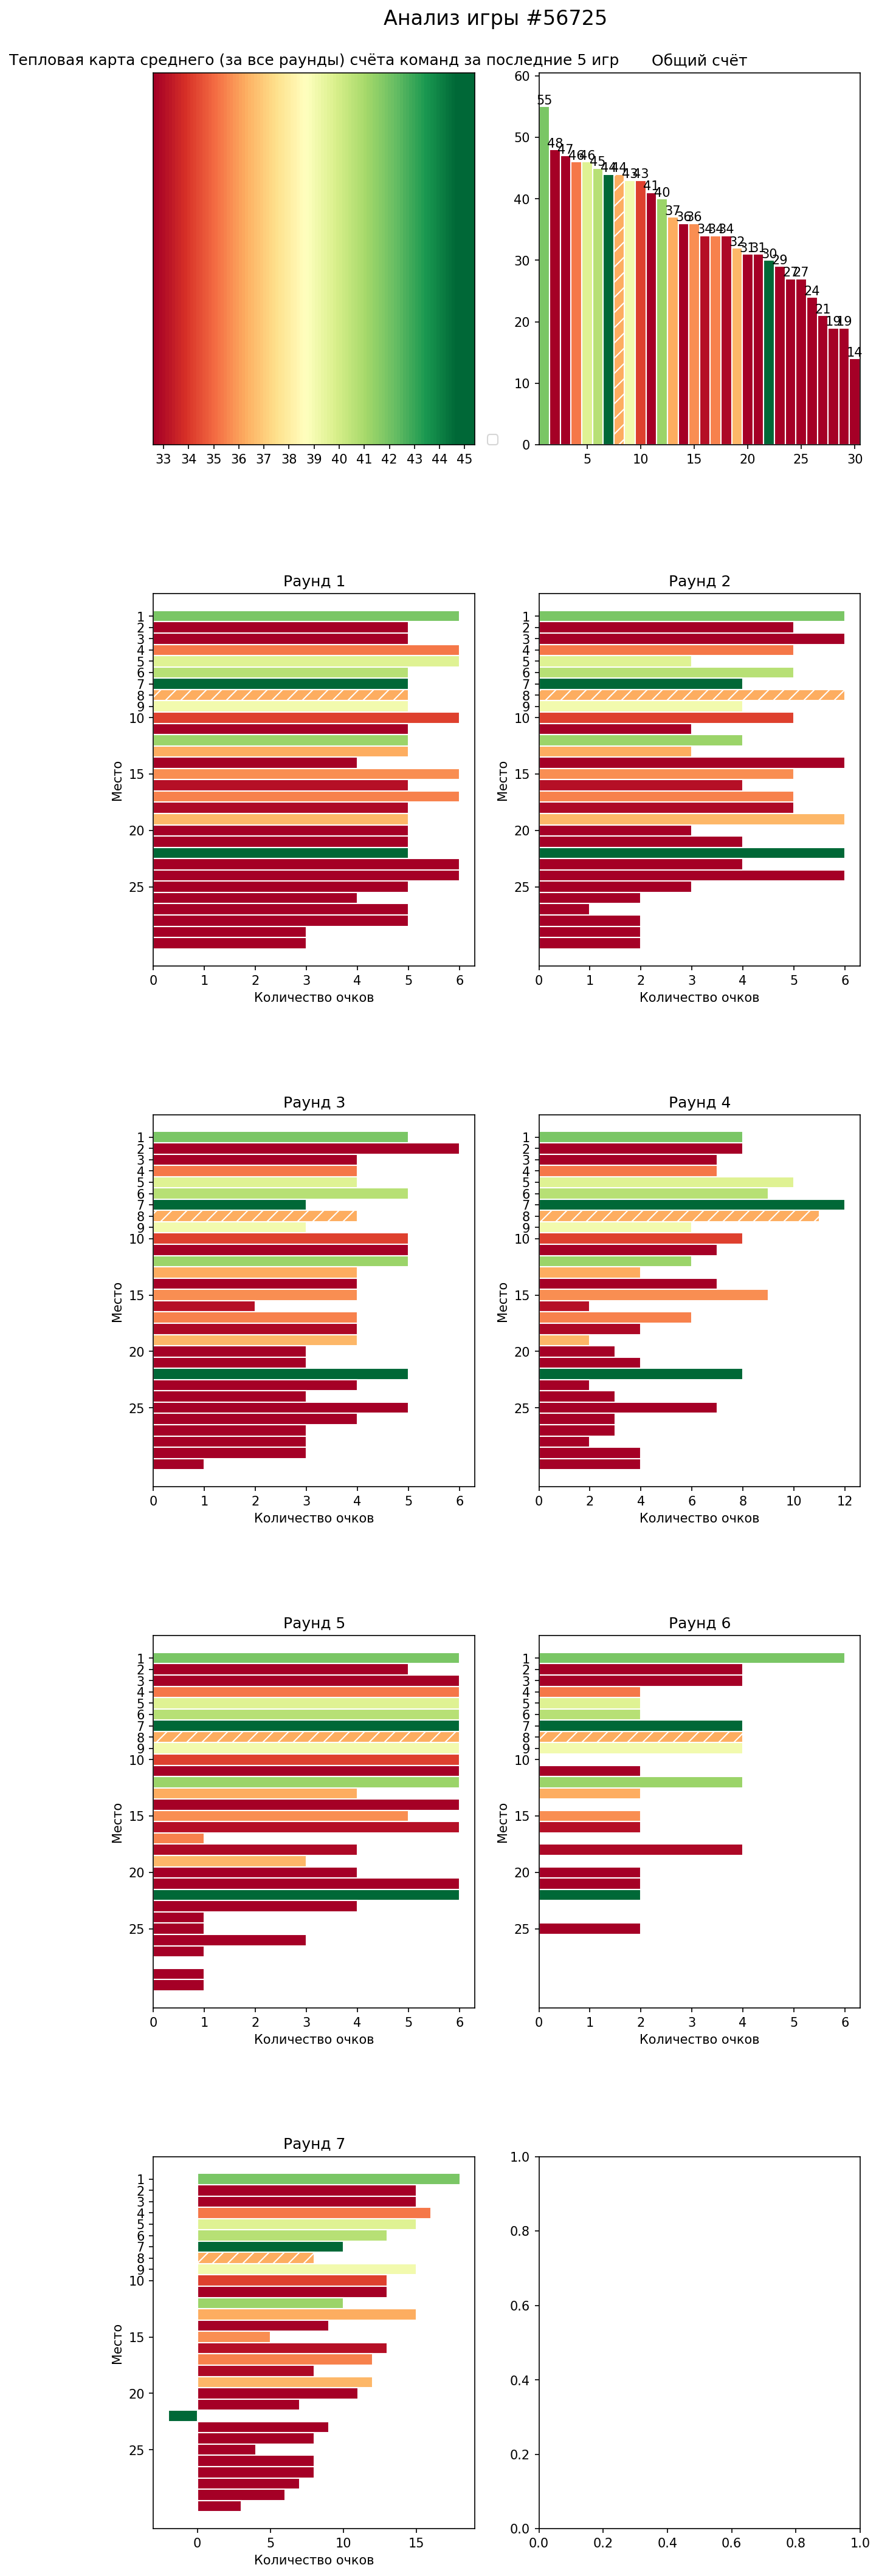

In [8]:
_ = create_graph_for_game_id_and_team(56725, 'Давайте ещё немного подумаем')
